In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
import sklearn.metrics as skm
import torchvision
from torchsummary import summary


import matplotlib.pyplot as plt
%matplotlib inline

import json
import pickle

C:\Users\AJ\anaconda3\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\AJ\anaconda3\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
#for gpu model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
torch.cuda.is_available()

True

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
#loading data from json file 
# path = '/content/drive/MyDrive/Colab Notebooks/data_test.json'
path = 'dataset/data_10.json'

with open(path,"r") as jsonLoad:
    mainData = json.load(jsonLoad)
    labels = mainData['labels']
    data = mainData['mfcc']
    mappings = mainData['mapping']
    

In [6]:
#inspection of data

print(mappings)
print(len(data))

dataT = torch.tensor(data).float()
labelsT = torch.tensor(labels).long()
print(dataT.shape)

#transform to 4d tensors 
mfccCoeff = dataT.view([5992,1,216,13]).float()
print(mfccCoeff.shape)
print(type(mfccCoeff))

['disco', 'metal', 'reggae', 'blues', 'rock', 'classical', 'jazz', 'hiphop', 'country', 'pop']
5992
torch.Size([5992, 216, 13])
torch.Size([5992, 1, 216, 13])
<class 'torch.Tensor'>


In [7]:
# print(dataT.shape)
print(labelsT.shape)

torch.unique(dataT)

torch.Size([5992])


tensor([-734.1906, -732.8031, -732.6166,  ...,  274.5250,  274.6183,
         276.7925])

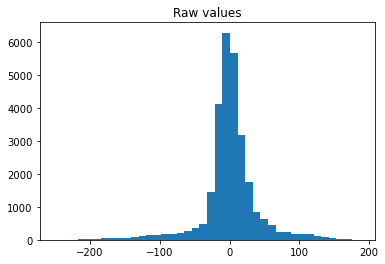

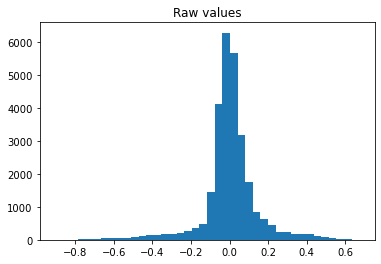

In [8]:
#normalization of data
plt.hist(mfccCoeff[:10,:,:,:].view(1,-1).detach(),40)
plt.title('Raw values')
plt.show()

mfccCoeff /= torch.max(mfccCoeff)
plt.hist(mfccCoeff[:10,:,:,:].view(1,-1).detach(),40)
plt.title('Raw values')
plt.show()

In [69]:
train_data,test_data,train_labels,test_labels = train_test_split(mfccCoeff,labelsT,test_size=.1)


train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

batchsize = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=False)
test_loader = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])


In [44]:
#check size
print(train_loader.dataset.tensors[0].shape)
print(train_loader.dataset.tensors[1].shape)

print('\n')
print(test_loader.dataset.tensors[0].shape)
print(test_loader.dataset.tensors[1].shape)

print(test_data.tensors[0].shape[0])

torch.Size([4793, 1, 216, 13])
torch.Size([4793])


torch.Size([1199, 1, 216, 13])
torch.Size([1199])
1199


In [63]:
def makeTheModel(printtoggle=False):
    class musicNet(nn.Module):
        def __init__(self,printtoggle):
            super().__init__()
            
            #printtoggle
            self.print = printtoggle
            
            #firstconvolution layer
            self.conv1 = nn.Conv2d(1,64,3,padding=1)
            self.bnorm1 = nn.BatchNorm2d(64) 
            
            #second convolution layer
            self.conv2 = nn.Conv2d(64,128,3,padding=1)
            self.bnorm2 = nn.BatchNorm2d(128)
            
            #linear layers
            self.fc1 = nn.Linear(54*3*128,256)
            self.fc2 = nn.Linear(256,64)
            self.fc3 = nn.Linear(64,10)
            
        def forward(self,x):
            
            if self.print: print(f'Input: {list(x.shape)}')
                
            #firstblock 
            x = F.leaky_relu( self.bnorm1( F.max_pool2d(self.conv1(x),2) ) )
            if self.print: print(f'First block : {list(x.shape)}')
            
            #secondblock
            x = F.leaky_relu( self.bnorm2( F.max_pool2d(self.conv2(x),2) ) )
            if self.print: print(f'Second block : {list(x.shape)}')
            
            #reshape for linear layer
            nUnits = x.shape.numel()/x.shape[0]
#             print(x.shape.numel()),print(x.shape[0]),print(nUnits)
            x = x.view(-1,int(nUnits))
            if self.print: print(f'Vectorized : {list(x.shape)}')

            #linear layer
            x = F.leaky_relu(self.fc1(x))
            x = F.dropout(x,p=.5,training=self.training)
            x = F.leaky_relu(self.fc2(x))
            x = F.dropout(x,p=.65,training=self.training)
            x = self.fc3(x)
            # print("'''''''")
            # print(x.shape)
            x = F.softmax(x,dim=-1)

            if self.print: print(f'Final output : {list(x.shape)}')
                
            return x
    
    #model instance
    net = musicNet(printtoggle)
    
    
    # print("Model's state_dict:")
    # for param_tensor in net.state_dict():
    #    print(param_tensor, "\t", net.state_dict()[param_tensor].size())
    
    #lossfun
    lossfun = nn.CrossEntropyLoss()
    
    #optimzer
    optimizer = torch.optim.Adam(net.parameters(),lr=.0001,weight_decay=1e-5)
    
    # print("Optimizer's state_dict:")
    # for var_name in optimizer.state_dict():
    #    print(var_name,"\t", optimizer.state_dict()[var_name])
    
    
    return net,lossfun,optimizer
                       

In [48]:
# test the model with one batch
net,lossfun,optimizer = makeTheModel(True)

X,y = iter(train_loader).next()
yHat = net(X)

# check size of output
print('\nOutput size:')
print(yHat.shape)

# # now let's compute the loss
loss = lossfun(yHat,torch.squeeze(y))
print(' ')
print('Loss:')
print(loss)

Input: [32, 1, 216, 13]
First block : [32, 64, 108, 6]
Second block : [32, 128, 54, 3]
Vectorized : [32, 20736]
Final output : [32, 10]

Output size:
torch.Size([32, 10])
 
Loss:
tensor(2.3031, grad_fn=<NllLossBackward0>)


In [57]:
#train model
def function2trainTheModel():

  # number of epochs
  numepochs = 50
  
  # create a new model
  net,lossfun,optimizer = makeTheModel()

  # send the model to the GPU
  net.to(device)

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  testLoss  = torch.zeros(numepochs)
  trainErr  = torch.zeros(numepochs)
  testErr   = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    net.train()
    batchLoss = []
    batchErr  = []
    for X,y in train_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss and error from this batch
      batchLoss.append(loss.item())
      batchErr.append( torch.mean((torch.argmax(yHat,axis=1) != y).float()).item() )
    # end of batch loop...

    # and get average losses and error rates across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainErr[epochi]  = 100*np.mean(batchErr)



    ### test performance
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader

    # push data to GPU
    X = X.to(device)
    y = y.to(device)

    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      loss = lossfun(yHat,y)
      
    # get loss and error rate from the test batch
    testLoss[epochi] = loss.item()
    testErr[epochi]  = 100*torch.mean((torch.argmax(yHat,axis=1) != y).float()).item()


  # end epochs

  # function output
  return trainLoss,testLoss,trainErr,testErr,net,yHat

In [64]:
trainLoss,testLoss,trainErr,testErr,netModule, y_predicted_feature = function2trainTheModel()

In [65]:
#for deploying model

# print(next(netModule.parameters()).is_cuda)   #checking whether module in gpu or cpu

print('Model state dict')
for param_tensor in netModule.state_dict():
    print(param_tensor,"\t",netModule.state_dict()[param_tensor].size())



path = '../musicgenre/model.pth'
torch.save(netModule.state_dict(),path)
    

Model state dict
conv1.weight 	 torch.Size([64, 1, 3, 3])
conv1.bias 	 torch.Size([64])
bnorm1.weight 	 torch.Size([64])
bnorm1.bias 	 torch.Size([64])
bnorm1.running_mean 	 torch.Size([64])
bnorm1.running_var 	 torch.Size([64])
bnorm1.num_batches_tracked 	 torch.Size([])
conv2.weight 	 torch.Size([128, 64, 3, 3])
conv2.bias 	 torch.Size([128])
bnorm2.weight 	 torch.Size([128])
bnorm2.bias 	 torch.Size([128])
bnorm2.running_mean 	 torch.Size([128])
bnorm2.running_var 	 torch.Size([128])
bnorm2.num_batches_tracked 	 torch.Size([])
fc1.weight 	 torch.Size([256, 20736])
fc1.bias 	 torch.Size([256])
fc2.weight 	 torch.Size([64, 256])
fc2.bias 	 torch.Size([64])
fc3.weight 	 torch.Size([10, 64])
fc3.bias 	 torch.Size([10])


# graphical representation part start


In [66]:
y_predicted = torch.argmax(y_predicted_feature.cpu(),axis=1)

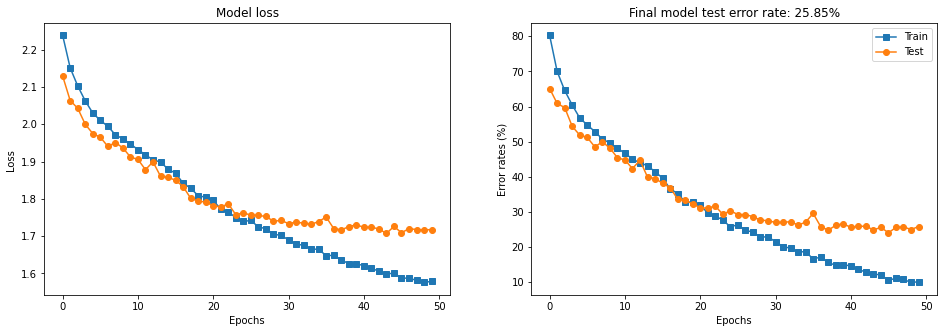

In [70]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss ')
ax[0].set_title('Model loss')

ax[1].plot(trainErr,'s-',label='Train')
ax[1].plot(testErr,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Error rates (%)')
ax[1].set_title(f'Final model test error rate: {testErr[-1]:.2f}%')
ax[1].legend()

plt.show()

In [1]:

from sklearn.metrics import classification_report
print(classification_report(test_labels.detach(),y_predicted))

NameError: name 'test_labels' is not defined

Text(114.0, 0.5, '\nGenre')

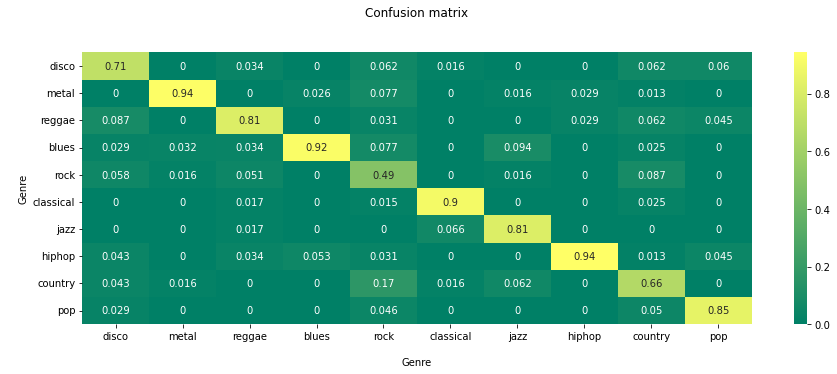

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
plt = plt.figure(figsize=(15,5))
c = skm.confusion_matrix(test_labels.detach(), y_predicted, normalize='pred')
plt_1 =sns.heatmap(c,annot=True,cmap='summer',xticklabels=mappings,yticklabels=mappings)
plt_1.set_title('Confusion matrix\n\n');
plt_1.set_xlabel('\nGenre')
plt_1.set_ylabel('\nGenre')






In [20]:
print(y_predicted.shape)

torch.Size([600])


In [21]:
print(test_labels.shape)
# print(test_labels)

torch.Size([600])


In [22]:
y_predicted_labels = torch.softmax(y_predicted_feature.cpu(),axis=1)

In [23]:
y_predicted_labels[1]

tensor([0.0853, 0.0853, 0.0853, 0.0853, 0.0853, 0.2320, 0.0853, 0.0853, 0.0853,
        0.0853])

In [24]:
map=['disco', 'metal', 'reggae', 'blues', 'rock', 'classical', 'jazz', 'hiphop', 'country', 'pop']

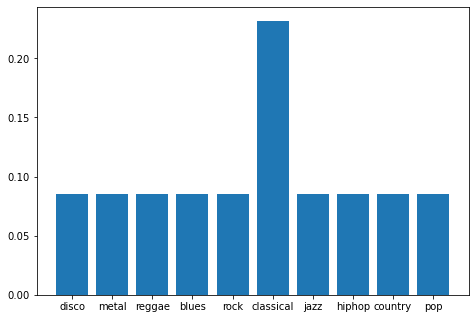

In [25]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['disco', 'metal', 'reggae', 'blues', 'rock', 'classical', 'jazz', 'hiphop', 'country', 'pop']

ax.bar(langs,y_predicted_labels[1])
plt.show()